In [289]:
import pandas as pd
import numpy as np
import sys
import warnings
import matplotlib.pyplot as plt

# Plots

In [290]:
def loss_curve_plot(y_line):
    x_line = list(range(len(y_line)))
    plt.plot(x_line, y_line, color = "red")
    plt.xlabel('iterations')
    plt.ylabel('cost function')
    plt.title("loss curve")
    plt.show()

# Data encoding

In [291]:
def data_encoding(df):
    # Convert to one-hot encoding
    df = df.dropna()
    df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent'], drop_first=True)

    # Convert boolean to int
    for column in df.columns.to_list():
        if "person_home_ownership" in column or "loan_intent" in column:
            df[column] = df[column].astype(int)

    # Convert categories to int
    with warnings.catch_warnings(action="ignore"):
        df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})
        df['loan_grade'] = df['loan_grade'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

    return df

# Split datasets

In [292]:
def split_len(total):
    return (int) ((total * 80)/100)

def split_dataset(df):
    train_df = df.iloc[:split_len(len(df))]
    test_df = df.iloc[split_len(len(df)):]
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

# Scaling

In [293]:
def z_score_normalization(feature):
    with warnings.catch_warnings(action="ignore"):
        feature_array = np.array(feature)
        mean = np.mean(feature_array)
        standard_deviation = np.std(feature_array)
        for i in range(len(feature)):
            feature[i] = (feature[i] - mean) / standard_deviation
        return feature

# Auto Convergence determination

In [294]:
# Auto Convergence
def has_converged(cost_change):
    epsilon = 0.00001
    if cost_change < 0:
        print("ERROR : Cost function increased from the previous iteration. Exiting ... ")
        sys.exit(1)
    if cost_change < epsilon:
        return True
    return False

# Compute Sigmoid 

$$g(z) = \frac{1}{1+e^{-z}}$$

In [295]:
def sigmoid(z):
    return 1/(1+(1/np.exp(z)))

# Cost Function with Regularization
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

In [296]:
def cost_function_reg(w, b, X, y, LAMBDA):
    m,n = X.shape
    cost = 0
    for i in range(m):
        f_wb = sigmoid((np.dot(w,X[i]) + b))
        loss = -y[i] * np.log(f_wb) - (1 - y[i]) * np.log(1 - f_wb)
        cost += loss
    cost = (1/m) * cost

    reg = 0
    for i in range(n):
        reg += w[i]**2

    reg = (LAMBDA/(2*m)) * reg
    return cost + reg

# Compute Gradient with Regularization
$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{1}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} + \frac{\lambda}{m}  \sum_{j=0}^{n-1} w_j\tag{2}
$$

In [297]:
def compute_gradient_reg(w, b, X, y, LAMBDA):
    m,n = X.shape
    dj_dw = np.zeros(n)
    dj_db = 0
    for i in range(m):
        f_wb = sigmoid(np.dot(w,X[i]) + b)
        dj_db += (f_wb - y[i])
        err = f_wb - y[i]
        for j in range(n):
            dj_dw[j] += err * X[i,j]
    
    dj_db = dj_db/m
    dj_dw = dj_dw/m

    for i in range(n):
        dj_dw[i] += ( LAMBDA / m ) * w[i]

    return dj_db, dj_dw

# Gradient Descent

In [298]:
def gradient_descent(w, b, X, y, LAMBDA, ALPHA):
    cost_history = []
    cost_history.append(cost_function_reg(w, b, X, y, LAMBDA))
    last_cost = cost_history[-1] + 1
    i = 0
    while not has_converged(last_cost - cost_history[-1]) :
        dj_db, dj_dw = compute_gradient_reg(w, b, X, y, LAMBDA)
        w = w - ALPHA * dj_dw
        b = b - ALPHA * dj_db
        last_cost = cost_history[-1]
        cost_history.append(cost_function_reg(w, b, X, y, LAMBDA))
        i += 1
    print (f"TOTAL ITERATIONS : {i}")
    return cost_history, w, b



# Train

In [299]:
def train(train_X, train_y, LAMBDA, ALPHA):
    w = np.zeros(train_X.shape[1])
    b = 0
    return gradient_descent(w, b, train_X, train_y, LAMBDA, ALPHA)


# Prediction

In [300]:
def predict(test_X, w, b):
    predictions = np.zeros(test_X.shape[0])
    for i in range(test_X.shape[0]):
        predictions[i] = 1 if sigmoid(np.dot(w, test_X[i]) + b ) >= 0.4 else 0
    return predictions

# Precision and Recall

In [301]:
def accuracy(prediction, truth):
    # Initialize counters
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives

    for true, pred in zip(truth, prediction):
        if pred == 1 and true == 1:
            TP += 1
        elif pred == 1 and true == 0:
            FP += 1
        elif pred == 0 and true == 1:
            FN += 1

    # Calculate precision and recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

# Driver Method

TOTAL ITERATIONS : 848


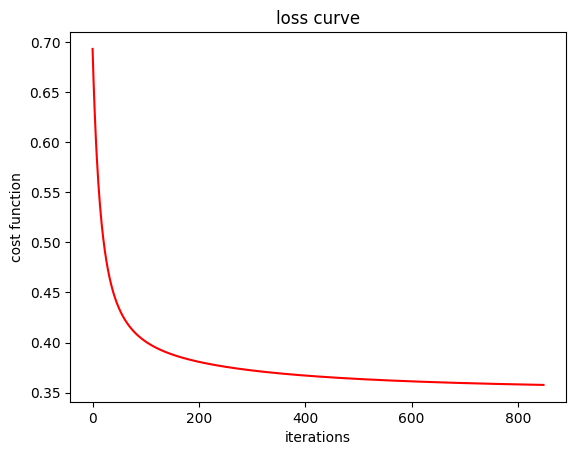

Precison : 0.6313446126447017
Recall : 0.6296625222024866


In [302]:
def main():
    df = pd.read_csv("/Users/abhijit/Downloads/credit_risk_dataset.csv")
    # print(df.head())
    df = data_encoding(df)
    train_df, test_df = split_dataset(df)
    # print(test_df.head())
    for column in [ "person_age", "person_income", "person_emp_length",	"loan_grade", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]:
        train_df[column] = z_score_normalization(train_df[column])
        test_df[column] = z_score_normalization(test_df[column])
    train_X = train_df.loc[:, train_df.columns != 'loan_status']
    train_y = train_df['loan_status'].to_numpy()
    test_X = test_df.loc[:, test_df.columns != 'loan_status']
    test_y = test_df['loan_status'].to_numpy()
    LAMBDA = 1
    ALPHA = 0.1
    cost_history, w, b = train(train_X.to_numpy(), train_y, LAMBDA, ALPHA)
    loss_curve_plot(cost_history)
    prediction = predict(test_X.to_numpy(), w, b)
    precision, recall = accuracy(prediction, test_y)
    print(f"Precison : {precision}")
    print(f"Recall : {recall}")
    
main()
    